In [ ]:
!pip install gensim wordcloud bs4 nltk wordcloud tkinter

In [2]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import pandas as pd
import re

from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tkinter import Tk, Canvas, Label, Scrollbar, Listbox, END, VERTICAL
import webbrowser

In [4]:
base_url = "https://www.moneycontrol.com/news/tags/companies.html"

is_appen_on_previous = True
data_path = 'full_news.csv'

if is_appen_on_previous:
    df = pd.read_csv(data_path)
    print("Last News on : ",df.iloc[0]['date time'])
    print("Total news : ",len(df))
    
news_data = []

Last News on :  February 19, 2024 04:56 PM IST
Total news :  1175


In [5]:
def extractNewsData(news):
    """
    Get insights of news component
    """
    news_json = {}
    
    # Skip ad tag;
    if not news.get('class') or 'clearfix' not in news.get('class'):
        return "ad";
    
    a = news.find('a')
    span = news.find('span')
    
    news_json['link'] = a.get('href')
    news_json['title'] = a.get('title')
    news_json['date time'] = span.text
    
    # Append on previous data
    if is_appen_on_previous and news_json['date time'] == df.iloc[0]['date time']:
        return None
    
    p = news.find_all('p')[0]
    news_json['desc'] = p.text
    news_json['content'] = getFullNewsText(news_json['link'])
#     news_json['stock id'] = getStockId(news_json['link'])
    return news_json

def getFullNewsText(link:str):
    """
    Get Full response or Full News Decription
    """
    response = requests.get(link)
    soup = BeautifulSoup(response.text,'html.parser')  
    try:
        paras = soup.find_all('div',id='contentdata')[0].find_all('p')
        text = ""
        for para in paras:
            text += para.text
    except Exception as err:
        try:
            text = soup.find('p','pro_artidesc').text
        except:
            return 
    
    return text


def fetchPage(page=None,verbose=True):
    """
    Fetch News Entire page and extract the data
    """
    
    url = base_url
    
    # fetching base page
    if page and page >= 2:
        url = f"{base_url}/page-{page}/"
    
    # for processing details
    if(verbose):
        print(url)
        
    response = requests.get(url)   # get new html data
    soup = BeautifulSoup(response.text,'html.parser')  # create soup  
    news_ul = soup.find_all("ul",id="cagetory")[0]   # extract news data conponent
    
    # For Skips Ad Tag
    if not news_ul:
        return True
    
    li = news_ul.find_all('li')  # get list of news
    for index,news in enumerate(li): # iterate news component for get more insights
        
        # logging
        if(verbose):
            print(index)
            
        # extract news insights
        news_json = extractNewsData(news)
        
        # return none if news already in DB not want to duplicate and want not to continue
        if not news_json:
            return None
        if news_json == 'ad':
            continue
        
        # save data
        news_data.append(news_json)
        
    # want not to continue if in the loop   
    return True   
 
# Convert Date string object to Date
def getDateObject(dateString:str,dateFormat='%B %d, %Y %I:%M %p'):
    dt_object = datetime.strptime(dateString, dateFormat)
    return dt_object

In [4]:
for page in range(1,31):
    print("fetching page -- ",page)
    try:
        if not fetchPage(page):
            continue
    except:
        continue

fetching page --  1
https://www.moneycontrol.com/news/tags/companies.html
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
fetching page --  2
https://www.moneycontrol.com/news/tags/companies.html/page-2/
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
fetching page --  3
https://www.moneycontrol.com/news/tags/companies.html/page-3/
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
fetching page --  4
https://www.moneycontrol.com/news/tags/companies.html/page-4/
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
fetching page --  5
https://www.moneycontrol.com/news/tags/companies.html/page-5/
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
fetching page --  6
https://www.moneycontrol.com/news/tags/companies.html/page-6/
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [12]:
new_df = pd.DataFrame(news_data)
full_df = pd.concat([new_df,df])
full_df.drop_duplicates(inplace=True)
full_df.to_csv("full_news.csv",index=False)
news_content = full_df['content'].dropna().to_list()
len(news_content)

1173

In [48]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

token_text = [word_tokenize(article.lower()) for article in news_content]

filter_text = [
    [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    for words in token_text
]

filter_text = [[word for word in words if len(word) > 3]
               for words in filter_text
               ]


In [50]:
dictionary = corpora.Dictionary(filter_text)
corpus = [dictionary.doc2bow(text) for text in filter_text]

In [51]:
lda_model = models.LdaModel(corpus,num_topics=10,id2word=dictionary,passes=15)

In [52]:
for topic in lda_model.print_topics():
    print(topic)

(0, '0.025*"adani" + 0.018*"energy" + 0.014*"company" + 0.013*"said" + 0.012*"group" + 0.010*"india" + 0.008*"green" + 0.008*"project" + 0.007*"wind" + 0.006*"billion"')
(1, '0.022*"company" + 0.018*"crore" + 0.011*"said" + 0.010*"share" + 0.010*"percent" + 0.008*"fund" + 0.007*"year" + 0.007*"investment" + 0.006*"investor" + 0.006*"india"')
(2, '0.012*"india" + 0.007*"said" + 0.007*"government" + 0.006*"production" + 0.006*"company" + 0.006*"year" + 0.005*"manufacturing" + 0.005*"apple" + 0.004*"world" + 0.004*"country"')
(3, '0.015*"percent" + 0.014*"crore" + 0.013*"growth" + 0.012*"revenue" + 0.011*"company" + 0.010*"year" + 0.010*"quarter" + 0.010*"market" + 0.010*"said" + 0.008*"india"')
(4, '0.015*"company" + 0.014*"crore" + 0.014*"project" + 0.013*"power" + 0.012*"said" + 0.010*"india" + 0.009*"order" + 0.007*"investment" + 0.006*"energy" + 0.006*"year"')
(5, '0.025*"said" + 0.020*"india" + 0.016*"company" + 0.010*"year" + 0.008*"cent" + 0.008*"also" + 0.008*"market" + 0.007*"ve

In [53]:
topic_terms = [lda_model.show_topic(i) for i in range(lda_model.num_topics)]

In [54]:
topic_dict = {term: strength for terms in topic_terms for term, strength in terms}

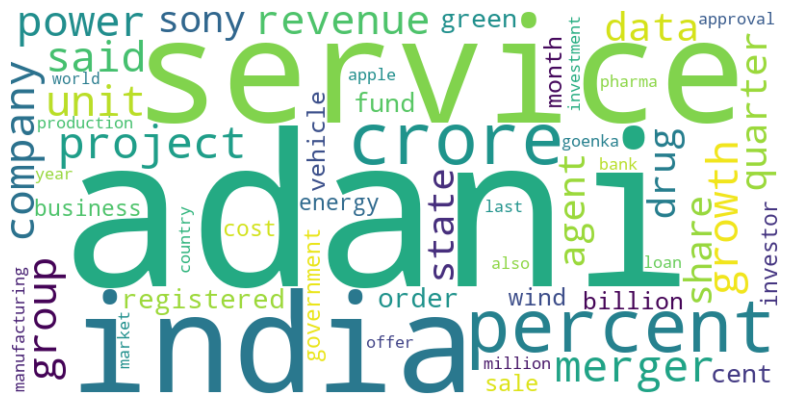

In [55]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

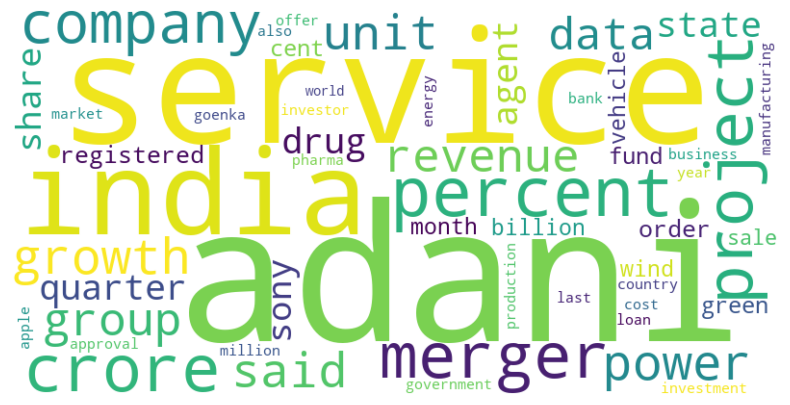

In [58]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

def display_related_news(word):
    search_url = f'https://www.google.com/search?q={word}'
    webbrowser.open(search_url)

# Create a GUI q with a listbox and scroll bar
root = Tk()
root.title("Word Cloud Explorer")

canvas = Canvas(root)
canvas.pack(side="left", fill="both", expand=True)

scrollbar = Scrollbar(root, command=canvas.yview)
scrollbar.pack(side="right", fill="y")

canvas.configure(yscrollcommand=scrollbar.set)
canvas.bind("<Configure>", lambda e: canvas.configure(scrollregion=canvas.bbox("all")))

frame = Label(canvas)
canvas.create_window((0, 0), window=frame, anchor="nw")

# Add words to the listbox and bind the click event
listbox = Listbox(frame, selectmode="single")
for term in topic_dict.keys():
    listbox.insert(END, term)
listbox.pack(side="left", fill="both")

listbox.bind("<ButtonRelease-1>", lambda event: display_related_news(listbox.get(listbox.curselection())))

# Start the GUI
root.mainloop()

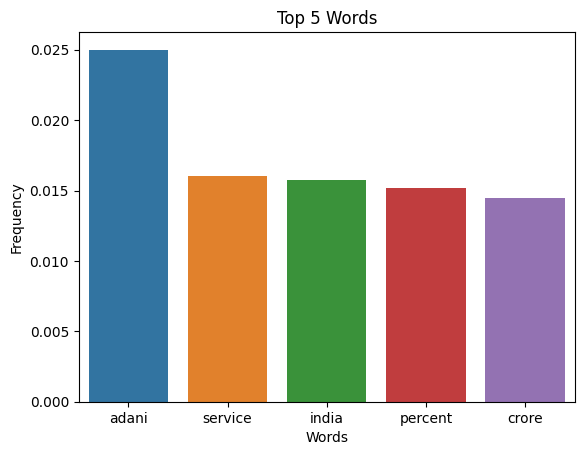

In [57]:
import seaborn as sns

sorted_data = dict(sorted(topic_dict.items(), key=lambda item: item[1], reverse=True))

# Extracting top 5 items
top_five = {k: sorted_data[k] for k in list(sorted_data)[:5]}

# Creating a bar plot
sns.barplot(x=list(top_five.keys()), y=list(top_five.values()))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Words')
plt.show()
